In [144]:
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from main.utils import data_manage_utils, train_utils

importlib.reload(train_utils)
importlib.reload(data_manage_utils)

loading_folder = "2024_06_17-0642"
loading_spec = "RF"

ROOT_PATH = os.path.abspath("../../")
TRAIN_DATA_FOLDER = os.path.join(ROOT_PATH, "data/training/training_results/", loading_spec, loading_folder)

# Finding corresponding prep data folder
settings_path = os.path.join(TRAIN_DATA_FOLDER, "estimation_settings.json")
PREP_DATA_FOLDER = data_manage_utils.find_data_path_by_settings_file(settings_path,ROOT_PATH)

In [145]:
pert_result_df_path = os.path.join(TRAIN_DATA_FOLDER,"pert_out_df.pkl.gz")

pert_df = pd.read_pickle(pert_result_df_path, compression="gzip")

pert_cols = list(set(pert_df.columns) - {"ARR_MIN_OF_DAY_COS", "ARR_MIN_OF_DAY_SIN", "ARR_DAY_SIN", "ARR_DAY_COS"})
USE_TH = False
if USE_TH:
    pert_cols = ["TEMP(C)","WIND_SPEED(KMH)","REL_HUMIDITY(PERCENT)","WIND_DRCT(DEG)", "SEA_LEVEL_PRESSURE(MILLIBAR)"]

pert_df

,DEP_DELAY(MINS),CRS_ELAPSED_TIME(MINS),NR_PREV_ARR_FLIGHTS(1HR),ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN,ARR_MIN_OF_DAY_COS,APPROACH_SPEED(KMH),TAIL_HEIGHT(M),PARKING_AREA(SQM),...,EVENT_HZ,EVENT_IC,EVENT_RA,EVENT_SN,EVENT_TS,RUNWAY_ERROR(PERC),y_true,pert_id,level,y
0,77,51,64,0.974928,-0.222521,-0.831470,-0.555570,259.280,6.324600,560.293571,...,0,0,0,0,0,1.00,2,DEP_DELAY(MINS)<6386798>,1,2
1,76,51,64,0.974928,-0.222521,-0.831470,-0.555570,259.280,6.324600,560.293571,...,0,0,0,0,0,1.00,2,DEP_DELAY(MINS)<6386798>,1,2
2,78,51,64,0.974928,-0.222521,-0.831470,-0.555570,259.280,6.324600,560.293571,...,0,0,0,0,0,1.00,2,DEP_DELAY(MINS)<6386798>,1,2
3,75,51,64,0.974928,-0.222521,-0.831470,-0.555570,259.280,6.324600,560.293571,...,0,0,0,0,0,1.00,2,DEP_DELAY(MINS)<6386798>,1,2
4,79,51,64,0.974928,-0.222521,-0.831470,-0.555570,259.280,6.324600,560.293571,...,0,0,0,0,0,1.00,2,DEP_DELAY(MINS)<6386798>,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16894120,2,69,96,0.433884,-0.900969,0.594823,-0.803857,255.576,9.000744,1525.176514,...,0,0,0,0,0,0.94,0,RUNWAY_ERROR(PERC)<6600848>,1,1
16894121,2,69,96,0.433884,-0.900969,0.594823,-0.803857,255.576,9.000744,1525.176514,...,0,0,0,0,0,0.64,0,RUNWAY_ERROR(PERC)<6600848>,1,1
16894122,2,69,96,0.433884,-0.900969,0.594823,-0.803857,255.576,9.000744,1525.176514,...,0,0,0,0,0,0.96,0,RUNWAY_ERROR(PERC)<6600848>,1,1
16894123,2,69,96,0.433884,-0.900969,0.594823,-0.803857,255.576,9.000744,1525.176514,...,0,0,0,0,0,0.62,0,RUNWAY_ERROR(PERC)<6600848>,1,1


In [146]:
y_test_pred = pd.DataFrame(data_manage_utils.load_numpy_from_pickle(os.path.join(TRAIN_DATA_FOLDER, "y_test_pred.pkl")))
y_test_pred

,0
0,2
1,0
2,1
3,2
4,0
...,...
65796,1
65797,1
65798,2
65799,0


In [147]:
X_test = pd.read_pickle(os.path.join(PREP_DATA_FOLDER, "X_test_df.pkl"))
y_test = pd.DataFrame(pd.read_pickle(os.path.join(PREP_DATA_FOLDER, "y_test_df.pkl")))
X_test

,DEP_DELAY(MINS),CRS_ELAPSED_TIME(MINS),NR_PREV_ARR_FLIGHTS(1HR),ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN,ARR_MIN_OF_DAY_COS,APPROACH_SPEED(KMH),TAIL_HEIGHT(M),PARKING_AREA(SQM),...,EVENT_FG,EVENT_FU,EVENT_GR,EVENT_GS,EVENT_HZ,EVENT_IC,EVENT_RA,EVENT_SN,EVENT_TS,RUNWAY_ERROR(PERC)
6386798,77,51,64,0.974928,-0.222521,-0.831470,-0.555570,259.280,6.324600,560.293571,...,0,0,0,0,0,0,0,0,0,1.0
6824913,-7,95,72,0.433884,-0.900969,-0.402747,-0.915311,257.428,9.043416,1075.157934,...,0,0,0,0,0,0,0,0,0,0.4
7556876,-2,86,51,0.000000,1.000000,-0.768842,-0.639439,259.280,6.324600,560.293571,...,0,0,0,0,0,0,0,0,0,0.2
10772416,162,95,84,0.000000,1.000000,0.480989,-0.876727,233.352,12.109704,1153.939056,...,0,0,0,0,0,0,0,0,0,0.0
7282245,-11,181,63,-0.433884,-0.900969,-0.942641,-0.333807,233.352,12.109704,1153.939056,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9980295,-3,102,68,-0.433884,-0.900969,0.731354,-0.681998,264.836,13.639800,2071.070234,...,0,0,0,0,0,0,0,0,0,0.8
9983451,-3,115,30,-0.433884,-0.900969,-0.342020,0.939693,261.132,12.624816,1445.094760,...,0,0,0,0,0,0,0,0,0,0.6
7026317,54,86,75,0.781831,0.623490,-0.816642,0.577145,255.576,9.000744,1525.176514,...,0,0,0,0,0,0,0,0,0,0.6
10352441,2,150,53,0.000000,1.000000,-0.980785,0.195090,261.132,12.624816,1445.094760,...,0,0,0,0,0,0,0,0,0,0.4


In [148]:
y_test

,ARR_DELAY_MINS
6386798,2
6824913,0
7556876,1
10772416,2
7282245,0
...,...
9980295,1
9983451,1
7026317,2
10352441,1


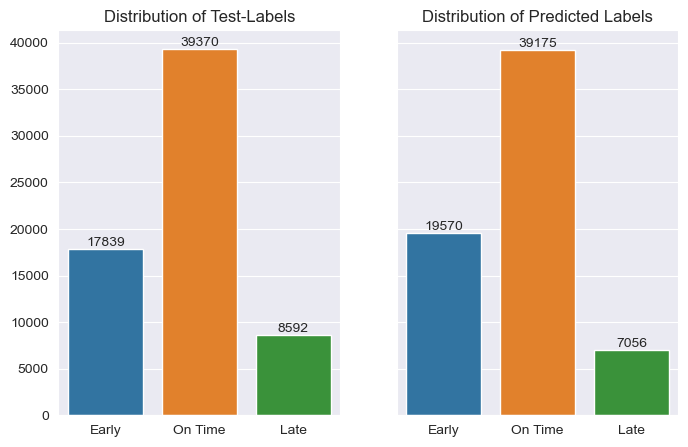

In [149]:
fig, axes = plt.subplots(1,2,figsize=(8,5), sharey=True)
sns.barplot(x=["Early", "On Time", "Late"], y=list(y_test.value_counts().sort_index()), ax=axes[0])
sns.barplot(x=["Early", "On Time", "Late"], y=list(y_test_pred.value_counts().sort_index()), ax=axes[1])
axes[0].set_title("Distribution of Test-Labels")
axes[1].set_title("Distribution of Predicted Labels")
axes[0].bar_label(axes[0].containers[0])
axes[1].bar_label(axes[1].containers[0])
plt.show()

In [150]:
def print_measures(y_pred, y_true, true_labels):
    if type(y_pred) == pd.DataFrame:
        y_pred = y_pred[y_pred.columns[0]]
    if type(y_true) == pd.DataFrame:
        y_true = y_true[y_true.columns[0]]
    ret_dict = {}
    print(20*"-")
    print(f"Global measures")
    print(f"Number of entries: {len(y_pred)}")
    acc = accuracy_score(y_true=y_true, y_pred=y_pred, normalize=True)
    ret_dict.update({"acc" : acc})
    print(f"Accuracy: {acc:.5f}")
    print(f"Precision-µ: {precision_score(y_true=y_true, y_pred=y_pred, average='micro'):.5f}")
    print(f"Recall-µ: {recall_score(y_true=y_true, y_pred=y_pred, average='micro'):.5f}")
    print(f"F1-Score-µ: {f1_score(y_true=y_true, y_pred=y_pred, average='micro'):.5f}")
    print("=")
    print(f"Precision-M: {precision_score(y_true=y_true, y_pred=y_pred, average='macro'):.5f}")
    print(f"Recall-M: {recall_score(y_true=y_true, y_pred=y_pred, average='macro'):.5f}")
    print(f"F1-Score-M: {f1_score(y_true=y_true, y_pred=y_pred, average='macro'):.5f}")
    for label in true_labels:
        if (label in y_pred) or (label in y_true):
            y_pred_filtered = [1 if val == label else 0 for val in y_pred]
            y_true_filtered = [1 if val == label else 0 for val in y_true]
            print(20*"-")
            print(f"Measures for label '{label}'")
            print(f"Number of entries: {sum(y_true_filtered)}")
            prec = precision_score(y_true=y_true_filtered, y_pred=y_pred_filtered)
            print(f"Precision score: {prec:.5f}")
            print(f"Recall score: {recall_score(y_true=y_true_filtered, y_pred=y_pred_filtered):.5f}")
            ret_dict.update({"prec"+str(label) : prec})
    return ret_dict
real = print_measures(y_test_pred, y_test, [0,1,2])

--------------------
Global measures
Number of entries: 65801
Accuracy: 0.73429
Precision-µ: 0.73429
Recall-µ: 0.73429
F1-Score-µ: 0.73429
=
Precision-M: 0.75099
Recall-M: 0.71565
F1-Score-M: 0.73029
--------------------
Measures for label '0'
Number of entries: 17839
Precision score: 0.58298
Recall score: 0.63955
--------------------
Measures for label '1'
Number of entries: 39370
Precision score: 0.78223
Recall score: 0.77836
--------------------
Measures for label '2'
Number of entries: 8592
Precision score: 0.88776
Recall score: 0.72905


## Finding amount of alerts in the data.
The 2 tables below depict the amount of alarmed perturbation cases within the result data.
The first table groups the data, such that only the predicted target with its min and max value within a given perturbation scenario is printed. 
This is used to find scenarios, where the min and max values deviate which means that the perturbation lead to varying results

In [151]:
X_pert_res = pert_df.groupby("pert_id").agg({'y':['min','max']})["y"]
X_pert_res

,min,max
pert_id,,
1HOUR_PRECIPITATION(INCH)<10001243>,1,1
1HOUR_PRECIPITATION(INCH)<10003947>,1,1
1HOUR_PRECIPITATION(INCH)<10004727>,1,1
1HOUR_PRECIPITATION(INCH)<10006126>,1,1
1HOUR_PRECIPITATION(INCH)<10006791>,1,1
...,...,...
WINGLETS(YN)<9998396>,0,0
WINGLETS(YN)<9998430>,2,2
WINGLETS(YN)<9998460>,1,1


In [152]:
pert_alerts = X_pert_res[~(X_pert_res["min"] == X_pert_res["max"])]
pert_alerts

,min,max
pert_id,,
1HOUR_PRECIPITATION(INCH)<10026093>,0,1
1HOUR_PRECIPITATION(INCH)<10042426>,0,1
1HOUR_PRECIPITATION(INCH)<10042665>,0,1
1HOUR_PRECIPITATION(INCH)<10055239>,0,1
1HOUR_PRECIPITATION(INCH)<10055441>,0,1
...,...,...
WINGLETS(YN)<9950165>,0,1
WINGLETS(YN)<9966554>,0,1
WINGLETS(YN)<9969420>,0,1


Now we want to find all single perturbation rows within the result and find all that are related to the alarmed scenarios.

In [153]:
list(pert_alerts.index)
pert_df[pert_df["pert_id"].isin(list(pert_alerts.index))]

,DEP_DELAY(MINS),CRS_ELAPSED_TIME(MINS),NR_PREV_ARR_FLIGHTS(1HR),ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN,ARR_MIN_OF_DAY_COS,APPROACH_SPEED(KMH),TAIL_HEIGHT(M),PARKING_AREA(SQM),...,EVENT_HZ,EVENT_IC,EVENT_RA,EVENT_SN,EVENT_TS,RUNWAY_ERROR(PERC),y_true,pert_id,level,y
11,-7,95,72,0.433884,-0.900969,-0.402747,-0.915311,257.428,9.043416,1075.157934,...,0,0,0,0,0,0.40,0,DEP_DELAY(MINS)<6824913>,1,0
12,-8,95,72,0.433884,-0.900969,-0.402747,-0.915311,257.428,9.043416,1075.157934,...,0,0,0,0,0,0.40,0,DEP_DELAY(MINS)<6824913>,1,0
13,-6,95,72,0.433884,-0.900969,-0.402747,-0.915311,257.428,9.043416,1075.157934,...,0,0,0,0,0,0.40,0,DEP_DELAY(MINS)<6824913>,1,0
14,-9,95,72,0.433884,-0.900969,-0.402747,-0.915311,257.428,9.043416,1075.157934,...,0,0,0,0,0,0.40,0,DEP_DELAY(MINS)<6824913>,1,0
15,-5,95,72,0.433884,-0.900969,-0.402747,-0.915311,257.428,9.043416,1075.157934,...,0,0,0,0,0,0.40,0,DEP_DELAY(MINS)<6824913>,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16893854,-5,171,65,0.433884,-0.900969,-0.555570,0.831470,255.576,9.000744,1525.176514,...,0,0,0,0,0,0.94,0,RUNWAY_ERROR(PERC)<6949065>,1,0
16893855,-5,171,65,0.433884,-0.900969,-0.555570,0.831470,255.576,9.000744,1525.176514,...,0,0,0,0,0,0.64,0,RUNWAY_ERROR(PERC)<6949065>,1,1
16893856,-5,171,65,0.433884,-0.900969,-0.555570,0.831470,255.576,9.000744,1525.176514,...,0,0,0,0,0,0.96,0,RUNWAY_ERROR(PERC)<6949065>,1,0
16893857,-5,171,65,0.433884,-0.900969,-0.555570,0.831470,255.576,9.000744,1525.176514,...,0,0,0,0,0,0.62,0,RUNWAY_ERROR(PERC)<6949065>,1,1


## Creating the Ourcome DF
Usign the last four columns in the above df, we see the mode, index and results of ALL perturbation scenarios. Not only the alarmed values. 

In [154]:
pert_outcomes = pert_df[pert_df.columns[-4:]]
pert_outcomes

,y_true,pert_id,level,y
0,2,DEP_DELAY(MINS)<6386798>,1,2
1,2,DEP_DELAY(MINS)<6386798>,1,2
2,2,DEP_DELAY(MINS)<6386798>,1,2
3,2,DEP_DELAY(MINS)<6386798>,1,2
4,2,DEP_DELAY(MINS)<6386798>,1,2
...,...,...,...,...
16894120,0,RUNWAY_ERROR(PERC)<6600848>,1,1
16894121,0,RUNWAY_ERROR(PERC)<6600848>,1,1
16894122,0,RUNWAY_ERROR(PERC)<6600848>,1,1
16894123,0,RUNWAY_ERROR(PERC)<6600848>,1,1


## Disassembling the perturbation ID colun to make it more readable and get index and column label information

In [155]:
def disassemble_pert_id(row):
    s = row["pert_id"].split("<")
    col = s[0]
    idx = s[1][:-1]
    val = row[col]
    return [col,val,idx]

col_values = pert_df.apply(lambda row: disassemble_pert_id(row), axis=1)

In [156]:
col_values = pd.DataFrame(list(col_values.to_numpy()), columns=["column","val","idx"])
col_values

,column,val,idx
0,DEP_DELAY(MINS),77.00,6386798
1,DEP_DELAY(MINS),76.00,6386798
2,DEP_DELAY(MINS),78.00,6386798
3,DEP_DELAY(MINS),75.00,6386798
4,DEP_DELAY(MINS),79.00,6386798
...,...,...,...
16894120,RUNWAY_ERROR(PERC),0.94,6600848
16894121,RUNWAY_ERROR(PERC),0.64,6600848
16894122,RUNWAY_ERROR(PERC),0.96,6600848
16894123,RUNWAY_ERROR(PERC),0.62,6600848


In [157]:
col_values[col_values["column"] == "REL_HUMIDITY(PERCENT)"]

,column,val,idx
8062548,REL_HUMIDITY(PERCENT),93.18000,6386798
8062549,REL_HUMIDITY(PERCENT),92.99364,6386798
8062550,REL_HUMIDITY(PERCENT),93.36636,6386798
8062551,REL_HUMIDITY(PERCENT),92.80728,6386798
8062552,REL_HUMIDITY(PERCENT),93.55272,6386798
...,...,...,...
9312762,REL_HUMIDITY(PERCENT),58.68018,6600848
9312763,REL_HUMIDITY(PERCENT),56.94408,6600848
9312764,REL_HUMIDITY(PERCENT),58.79592,6600848
9312765,REL_HUMIDITY(PERCENT),56.82834,6600848


In [158]:
pert_outcomes["column"] = list(col_values["column"])
pert_outcomes["val"] = list(col_values["val"])
pert_outcomes["idx"] = list(col_values["idx"])
pert_outcomes

,y_true,pert_id,level,y,column,val,idx
0,2,DEP_DELAY(MINS)<6386798>,1,2,DEP_DELAY(MINS),77.00,6386798
1,2,DEP_DELAY(MINS)<6386798>,1,2,DEP_DELAY(MINS),76.00,6386798
2,2,DEP_DELAY(MINS)<6386798>,1,2,DEP_DELAY(MINS),78.00,6386798
3,2,DEP_DELAY(MINS)<6386798>,1,2,DEP_DELAY(MINS),75.00,6386798
4,2,DEP_DELAY(MINS)<6386798>,1,2,DEP_DELAY(MINS),79.00,6386798
...,...,...,...,...,...,...,...
16894120,0,RUNWAY_ERROR(PERC)<6600848>,1,1,RUNWAY_ERROR(PERC),0.94,6600848
16894121,0,RUNWAY_ERROR(PERC)<6600848>,1,1,RUNWAY_ERROR(PERC),0.64,6600848
16894122,0,RUNWAY_ERROR(PERC)<6600848>,1,1,RUNWAY_ERROR(PERC),0.96,6600848
16894123,0,RUNWAY_ERROR(PERC)<6600848>,1,1,RUNWAY_ERROR(PERC),0.62,6600848


In [159]:
pert_view = pert_outcomes.groupby(["pert_id","y_true"]).first().reset_index().set_index('pert_id')
pert_view

,y_true,level,y,column,val,idx
pert_id,,,,,,
1HOUR_PRECIPITATION(INCH)<10001243>,1,3,1,1HOUR_PRECIPITATION(INCH),0.000,10001243
1HOUR_PRECIPITATION(INCH)<10003947>,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,10003947
1HOUR_PRECIPITATION(INCH)<10004727>,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,10004727
1HOUR_PRECIPITATION(INCH)<10006126>,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,10006126
1HOUR_PRECIPITATION(INCH)<10006791>,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,10006791
...,...,...,...,...,...,...
WINGLETS(YN)<9998396>,0,1,0,WINGLETS(YN),0.000,9998396
WINGLETS(YN)<9998430>,2,1,2,WINGLETS(YN),1.000,9998430
WINGLETS(YN)<9998460>,1,1,1,WINGLETS(YN),0.000,9998460


## Create pert_alarm column
The pert_view DataFrame has been established. Now we add some flags to easily find whether or not a given entry is part of a "alarmed" entry or not.   

In [160]:
pert_view["pert_alarm"] = [idx in pert_alerts.index for idx in pert_view.index]
faulty = pert_view[pert_view["y_true"] != pert_view["y"]]
faulty_and_changed = faulty[faulty["pert_alarm"]]
pert_view["class_error"] = [idx in faulty.index for idx in pert_view.index]
pert_view

,y_true,level,y,column,val,idx,pert_alarm,class_error
pert_id,,,,,,,,
1HOUR_PRECIPITATION(INCH)<10001243>,1,3,1,1HOUR_PRECIPITATION(INCH),0.000,10001243,False,False
1HOUR_PRECIPITATION(INCH)<10003947>,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,10003947,False,False
1HOUR_PRECIPITATION(INCH)<10004727>,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,10004727,False,False
1HOUR_PRECIPITATION(INCH)<10006126>,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,10006126,False,False
1HOUR_PRECIPITATION(INCH)<10006791>,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,10006791,False,False
...,...,...,...,...,...,...,...,...
WINGLETS(YN)<9998396>,0,1,0,WINGLETS(YN),0.000,9998396,False,False
WINGLETS(YN)<9998430>,2,1,2,WINGLETS(YN),1.000,9998430,False,False
WINGLETS(YN)<9998460>,1,1,1,WINGLETS(YN),0.000,9998460,False,False


## First measures for subsets on perturbation data. Option per option view

In [161]:
counts = pert_view[pert_view["pert_alarm"]]["column"].value_counts()
percs = pert_view[pert_view["pert_alarm"]]["column"].value_counts(normalize=True)*100
pd.concat([counts, percs], axis=1, keys=['count', 'percenage'])

,count,percenage
DEP_DELAY(MINS),29237,54.522229
1HOUR_PRECIPITATION(INCH),4777,8.908325
EVENT_RA,3756,7.004326
CRS_ELAPSED_TIME(MINS),3676,6.855139
APPROACH_SPEED(KMH),2658,4.956736
SEA_LEVEL_PRESSURE(MILLIBAR),1727,3.220573
RUNWAY_ERROR(PERC),1510,2.815903
REL_HUMIDITY(PERCENT),1180,2.200507
PARKING_AREA(SQM),940,1.752946
NR_PREV_ARR_FLIGHTS(1HR),821,1.531031


Find number of alarms by level

In [162]:
counts_total = pert_view["level"].value_counts()
counts = pert_view[pert_view["pert_alarm"]]["level"].value_counts()
percs = (counts / counts_total) *100
#perc_of_all = pd.DataFrame([x/len(pert_view)*100 for x in counts])
pd.concat([counts_total,counts, percs], axis=1, keys=['total # of options', '# of alarming options', 'alarm percentages'])

,total # of options,# of alarming options,alarm percentages
1,723811,44851.0,6.196507
2,592209,NaN,NaN
3,460607,8773.0,1.904661


In [163]:
print(f"All lvl 1 pert columns: ")
print(list(pert_view[(pert_view["level"] == 1)]["column"].unique()))
print(f"Alarmed lvl 1 pert columns: ")
print(list(pert_view[(pert_view["level"] == 1) & (pert_view["pert_alarm"] == True)]["column"].unique()))

All lvl 1 pert columns: 
['APPROACH_SPEED(KMH)', 'CRS_ELAPSED_TIME(MINS)', 'DEP_DELAY(MINS)', 'EVENT_RA', 'EVENT_TS', 'NR_PREV_ARR_FLIGHTS(1HR)', 'PARKING_AREA(SQM)', 'RUNWAY_ERROR(PERC)', 'TAIL_HEIGHT(M)', 'VISIBILITY(MILES)', 'WINGLETS(YN)']
Alarmed lvl 1 pert columns: 
['APPROACH_SPEED(KMH)', 'CRS_ELAPSED_TIME(MINS)', 'DEP_DELAY(MINS)', 'EVENT_RA', 'EVENT_TS', 'NR_PREV_ARR_FLIGHTS(1HR)', 'PARKING_AREA(SQM)', 'RUNWAY_ERROR(PERC)', 'TAIL_HEIGHT(M)', 'VISIBILITY(MILES)', 'WINGLETS(YN)']


In [164]:
print(f"All lvl 3 pert columns: ")
print(list(pert_view[(pert_view["level"] == 3)]["column"].unique()))
print(f"Alarmed lvl 3 pert columns: ")
print(list(pert_view[(pert_view["level"] == 3) & (pert_view["pert_alarm"] == True)]["column"].unique()))

All lvl 3 pert columns: 
['1HOUR_PRECIPITATION(INCH)', 'DEWPOINT_TEMP(C)', 'REL_HUMIDITY(PERCENT)', 'SEA_LEVEL_PRESSURE(MILLIBAR)', 'TEMP(C)', 'WIND_DRCT(DEG)', 'WIND_SPEED(KMH)']
Alarmed lvl 3 pert columns: 
['1HOUR_PRECIPITATION(INCH)', 'DEWPOINT_TEMP(C)', 'REL_HUMIDITY(PERCENT)', 'SEA_LEVEL_PRESSURE(MILLIBAR)', 'TEMP(C)', 'WIND_DRCT(DEG)', 'WIND_SPEED(KMH)']


In [165]:
pert_view[(pert_view['level'] == 1) & pert_view['pert_alarm']]

,y_true,level,y,column,val,idx,pert_alarm,class_error
pert_id,,,,,,,,
APPROACH_SPEED(KMH)<10026093>,1,1,0,APPROACH_SPEED(KMH),261.132,10026093,True,True
APPROACH_SPEED(KMH)<10042426>,0,1,0,APPROACH_SPEED(KMH),261.132,10042426,True,False
APPROACH_SPEED(KMH)<10042837>,1,1,1,APPROACH_SPEED(KMH),264.836,10042837,True,False
APPROACH_SPEED(KMH)<10044360>,1,1,1,APPROACH_SPEED(KMH),259.280,10044360,True,False
APPROACH_SPEED(KMH)<10045887>,1,1,1,APPROACH_SPEED(KMH),259.280,10045887,True,False
...,...,...,...,...,...,...,...,...
WINGLETS(YN)<9950165>,0,1,1,WINGLETS(YN),1.000,9950165,True,True
WINGLETS(YN)<9966554>,0,1,1,WINGLETS(YN),0.000,9966554,True,True
WINGLETS(YN)<9969420>,1,1,1,WINGLETS(YN),0.000,9969420,True,False


All columns are present when looking into the perturbation levels

In [166]:
lvl1_and_alarmed = pert_view[(pert_view['level'] == 1) & pert_view['pert_alarm'] == True]
lvl1_and_not_alarmed = pert_view[(pert_view['level'] == 1) & pert_view['pert_alarm'] == False]
lvl3_and_alarmed = pert_view[(pert_view['level'] == 3) & pert_view['pert_alarm'] == True]
lvl3_and_not_alarmed = pert_view[(pert_view['level'] == 3) & pert_view['pert_alarm'] == False]

print(f"Pert lvl 1 accuracy within alarmed values:\n\t{(len(lvl1_and_alarmed[lvl1_and_alarmed['class_error'] == False]) / len(lvl1_and_alarmed)) * 100:.2f}%")
print(f"Pert lvl 1 accuracy within non-alarmed values:\n\t{(len(lvl1_and_not_alarmed[lvl1_and_not_alarmed['class_error'] == False]) / len(lvl1_and_not_alarmed)) * 100:.2f}%")
print(40*"=")
print(f"Pert lvl 3 accuracy within alarmed values:\n\t{(len(lvl3_and_alarmed[lvl3_and_alarmed['class_error'] == False]) / len(lvl3_and_alarmed)) * 100:.2f}%")
print(f"Pert lvl 3 accuracy within non-alarmed values:\n\t{(len(lvl3_and_not_alarmed[lvl3_and_not_alarmed['class_error'] == False]) / len(lvl3_and_not_alarmed)) * 100:.2f}%")

Pert lvl 1 accuracy within alarmed values:
	57.05%
Pert lvl 1 accuracy within non-alarmed values:
	73.85%
Pert lvl 3 accuracy within alarmed values:
	49.04%
Pert lvl 3 accuracy within non-alarmed values:
	73.55%


In [167]:
pert_view[pert_view['pert_alarm'] & pert_view['class_error']]

,y_true,level,y,column,val,idx,pert_alarm,class_error
pert_id,,,,,,,,
1HOUR_PRECIPITATION(INCH)<10026093>,1,3,0,1HOUR_PRECIPITATION(INCH),0.0,10026093,True,True
1HOUR_PRECIPITATION(INCH)<10042665>,1,3,0,1HOUR_PRECIPITATION(INCH),0.0,10042665,True,True
1HOUR_PRECIPITATION(INCH)<10055239>,1,3,0,1HOUR_PRECIPITATION(INCH),0.0,10055239,True,True
1HOUR_PRECIPITATION(INCH)<10055554>,1,3,0,1HOUR_PRECIPITATION(INCH),0.0,10055554,True,True
1HOUR_PRECIPITATION(INCH)<10055618>,1,3,0,1HOUR_PRECIPITATION(INCH),0.0,10055618,True,True
...,...,...,...,...,...,...,...,...
WINGLETS(YN)<9927066>,0,1,1,WINGLETS(YN),1.0,9927066,True,True
WINGLETS(YN)<9929965>,1,1,2,WINGLETS(YN),0.0,9929965,True,True
WINGLETS(YN)<9950165>,0,1,1,WINGLETS(YN),1.0,9950165,True,True


In [168]:
# Prepare values.
total = len(pert_view)
error = len(pert_view[pert_view['class_error']])
no_error = len(pert_view[~pert_view['class_error']])
alarm = len(pert_view[pert_view['pert_alarm']])
no_alarm = len(pert_view[~pert_view['pert_alarm']])
# Combined
alarm_and_error = len(pert_view[pert_view['pert_alarm'] & pert_view['class_error']])
alarm_and_no_error = len(pert_view[pert_view['pert_alarm'] & ~pert_view['class_error']])
no_alarm_and_error = len(pert_view[~pert_view['pert_alarm'] & pert_view['class_error']])
no_alarm_and_no_error = len(pert_view[~pert_view['pert_alarm'] & ~pert_view['class_error']])

print(f"Basics:\n{40*'-'}")
print(f"Accuracy for all perturbation options: {(1 - error/total)*100:.3f}%")
print(f"Nr. of perturbation alarms for all perturbation options: {(alarm/total)*100:.3f}%")
print(40*"=")
print(f"Combined metrics:\n{40*'-'}")
print(f"Of all wrong classifications, % of alarmed cases: {(alarm_and_error/error)*100:.3f}%")
print(f"Of all true classifications, % of alarmed cases: {(alarm_and_no_error/no_error)*100:.3f}%")
print(40*'-')
print(f"Of all alarmed, % of true classifications: {(alarm_and_no_error/alarm)*100:.3f}%")
print(f"Of all alarmed, % of wrong classifications: {(alarm_and_error/alarm)*100:.3f}%")
print(40*'-')
print(f"Of all non-alarmed, % of true classifications: {(no_alarm_and_no_error/no_alarm)*100:.3f}%")
print(f"Of all non-alarmed, % of wrong classifications: {(no_alarm_and_error/no_alarm)*100:.3f}%")
print(40*'-')

Basics:
----------------------------------------
Accuracy for all perturbation options: 73.429%
Nr. of perturbation alarms for all perturbation options: 3.018%
Combined metrics:
----------------------------------------
Of all wrong classifications, % of alarmed cases: 5.028%
Of all true classifications, % of alarmed cases: 2.291%
----------------------------------------
Of all alarmed, % of true classifications: 55.738%
Of all alarmed, % of wrong classifications: 44.262%
----------------------------------------
Of all non-alarmed, % of true classifications: 73.980%
Of all non-alarmed, % of wrong classifications: 26.020%
----------------------------------------


In [169]:
cols = list(pert_view["column"].value_counts().index)
cols

['1HOUR_PRECIPITATION(INCH)',
 'EVENT_SN',
 'WIND_SPEED(KMH)',
 'WIND_DRCT(DEG)',
 'VISIBILITY(MILES)',
 'TEMP(C)',
 'TAIL_HEIGHT(M)',
 'SEA_LEVEL_PRESSURE(MILLIBAR)',
 'RUNWAY_ERROR(PERC)',
 'REL_HUMIDITY(PERCENT)',
 'PARKING_AREA(SQM)',
 'NR_PREV_ARR_FLIGHTS(1HR)',
 'EVENT_TS',
 'EVENT_RA',
 'APPROACH_SPEED(KMH)',
 'EVENT_IC',
 'EVENT_HZ',
 'EVENT_GS',
 'EVENT_GR',
 'EVENT_FU',
 'EVENT_FG',
 'EVENT_DZ',
 'EVENT_BR',
 'DEWPOINT_TEMP(C)',
 'DEP_DELAY(MINS)',
 'CRS_ELAPSED_TIME(MINS)',
 'WINGLETS(YN)']

,y_true,level,y,column,val,pert_alarm,class_error
idx,,,,,,,
10001243,1,3,1,1HOUR_PRECIPITATION(INCH),0.000,False,False
10003947,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,False,False
10004727,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,False,False
10006126,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,False,False
10006791,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,False,False
...,...,...,...,...,...,...,...
9998396,0,3,0,1HOUR_PRECIPITATION(INCH),0.000,False,False
9998430,2,3,2,1HOUR_PRECIPITATION(INCH),0.000,False,False
9998460,1,3,1,1HOUR_PRECIPITATION(INCH),0.000,False,False


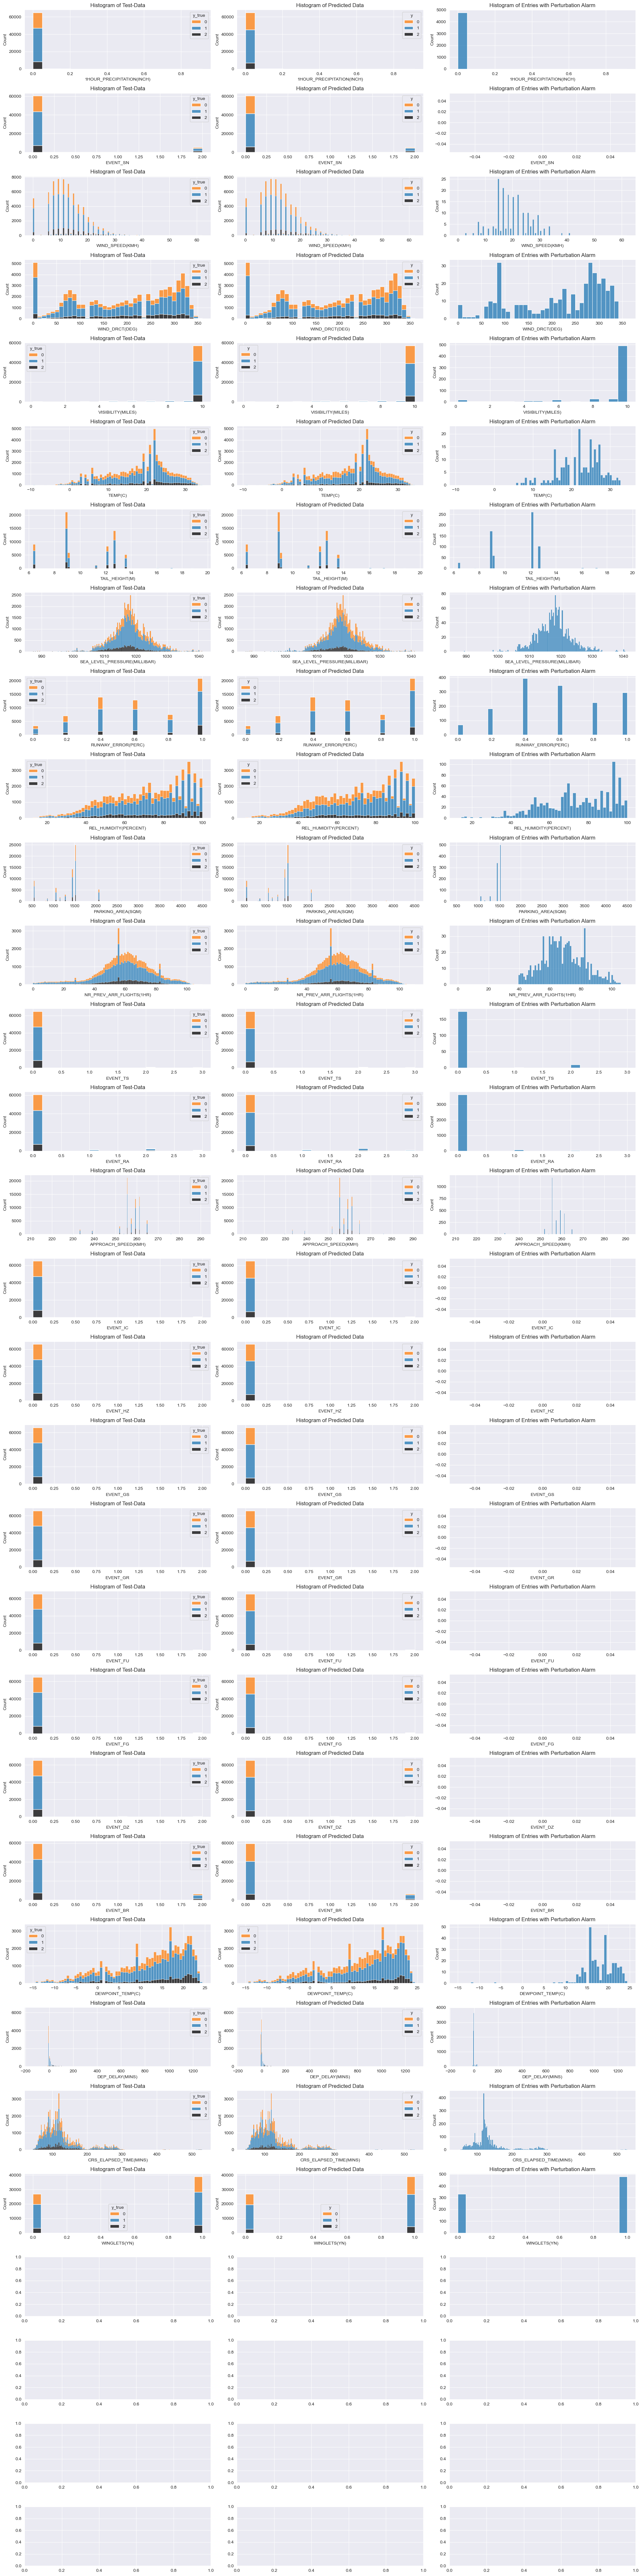

In [170]:
pert_view_alert = pert_view[pert_view["pert_alarm"] == True]

fig, axes = plt.subplots(len(pert_cols),3, figsize=(20,80))

count = 0
for col in cols:
    p_row = int(count / 3)
    bins = np.histogram_bin_edges(pert_view[pert_view["column"] == col]["val"], bins='auto')
    ax = sns.histplot(data = pert_view[pert_view["column"] == col], x = "val", hue="y_true", multiple="stack", ax=axes[p_row][0], bins=bins, palette = ["C1", "C0", "k"])
    axes[p_row][0].set_title("Histogram of Test-Data")
    ax.set(xlabel=col)
    ax = sns.histplot(data = pert_view[pert_view["column"] == col], x = "val", hue="y", multiple="stack", ax=axes[p_row][1], bins=bins, palette = ["C1", "C0", "k"])
    axes[p_row][1].set_title("Histogram of Predicted Data")
    ax.set(xlabel=col)
    ax = sns.histplot(data = pert_view_alert[pert_view_alert["column"] == col], x = "val", multiple="stack", ax=axes[p_row][2], bins = bins)
    axes[p_row][2].set_title("Histogram of Entries with Perturbation Alarm")
    ax.set(xlabel=col)
    count += 3
fig.tight_layout()
pert_view.groupby("idx").first()

In [171]:
def to_set(x):

    return set(x)

pert_view["y_outcomes"] = list(pert_outcomes[["pert_id" , "y"]].groupby("pert_id")["y"].apply(set).reset_index()["y"].to_numpy())
pert_view

,y_true,level,y,column,val,idx,pert_alarm,class_error,y_outcomes
pert_id,,,,,,,,,
1HOUR_PRECIPITATION(INCH)<10001243>,1,3,1,1HOUR_PRECIPITATION(INCH),0.000,10001243,False,False,{1}
1HOUR_PRECIPITATION(INCH)<10003947>,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,10003947,False,False,{1}
1HOUR_PRECIPITATION(INCH)<10004727>,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,10004727,False,False,{1}
1HOUR_PRECIPITATION(INCH)<10006126>,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,10006126,False,False,{1}
1HOUR_PRECIPITATION(INCH)<10006791>,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,10006791,False,False,{1}
...,...,...,...,...,...,...,...,...,...
WINGLETS(YN)<9998396>,0,1,0,WINGLETS(YN),0.000,9998396,False,False,{0}
WINGLETS(YN)<9998430>,2,1,2,WINGLETS(YN),1.000,9998430,False,False,{2}
WINGLETS(YN)<9998460>,1,1,1,WINGLETS(YN),0.000,9998460,False,False,{1}


In [172]:
def find_diff(x):
    return list(x.y_outcomes.difference({x.y}))

pert_view["changed_to"] = pert_view.apply( find_diff , axis = "columns")

In [173]:
def is_good_change(x):
    return x.y_true in x.changed_to

pert_view["corrected"] = list(pert_view[["y_true", "changed_to"]].apply(is_good_change, axis = "columns"))

In [174]:
def is_bad_change(x):
    if not x.class_error and x.changed_to:
        return True
    return False

pert_view["worsened"] = list(pert_view[["class_error", "changed_to"]].apply(is_bad_change, axis = "columns"))

In [175]:
pert_view

,y_true,level,y,column,val,idx,pert_alarm,class_error,y_outcomes,changed_to,corrected,worsened
pert_id,,,,,,,,,,,,
1HOUR_PRECIPITATION(INCH)<10001243>,1,3,1,1HOUR_PRECIPITATION(INCH),0.000,10001243,False,False,{1},[],False,False
1HOUR_PRECIPITATION(INCH)<10003947>,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,10003947,False,False,{1},[],False,False
1HOUR_PRECIPITATION(INCH)<10004727>,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,10004727,False,False,{1},[],False,False
1HOUR_PRECIPITATION(INCH)<10006126>,1,3,1,1HOUR_PRECIPITATION(INCH),0.075,10006126,False,False,{1},[],False,False
1HOUR_PRECIPITATION(INCH)<10006791>,1,3,1,1HOUR_PRECIPITATION(INCH),0.010,10006791,False,False,{1},[],False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
WINGLETS(YN)<9998396>,0,1,0,WINGLETS(YN),0.000,9998396,False,False,{0},[],False,False
WINGLETS(YN)<9998430>,2,1,2,WINGLETS(YN),1.000,9998430,False,False,{2},[],False,False
WINGLETS(YN)<9998460>,1,1,1,WINGLETS(YN),0.000,9998460,False,False,{1},[],False,False


In [176]:
def get_first(x):
    return x[0]

def find_union(x):
    return set().union(*x)

def get_indicator(x):
    return sum(x) / len(pert_cols)

pert_test_results = pert_view.groupby("idx").agg({"y_true" : get_first, "y" : pd.Series.mode, "pert_alarm" : max, "y_outcomes" : find_union, "changed_to" : find_union, "corrected" : get_indicator , "worsened" : get_indicator})
pert_test_results

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened
idx,,,,,,,
10001243,1,1,False,{1},{},0.0,0.0
10003947,1,1,False,{1},{},0.0,0.0
10004727,1,1,False,{1},{},0.0,0.0
10006126,1,1,False,{1},{},0.0,0.0
10006791,1,1,False,{1},{},0.0,0.0
...,...,...,...,...,...,...,...
9998396,0,0,False,{0},{},0.0,0.0
9998430,2,2,False,{2},{},0.0,0.0
9998460,1,1,False,{1},{},0.0,0.0


In [177]:
pert_test_results[pert_test_results["pert_alarm"]]

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened
idx,,,,,,,
10007456,2,1,True,"{1, 2}",{2},0.032258,0.000000
10007538,0,1,True,"{0, 1}",{0},0.032258,0.000000
10007615,1,2,True,"{1, 2}",{1},0.032258,0.000000
10007903,1,1,True,"{1, 2}",{2},0.000000,0.032258
10008040,1,1,True,"{1, 2}",{2},0.000000,0.032258
...,...,...,...,...,...,...,...
9998021,1,0,True,"{0, 1}",{1},0.032258,0.000000
9998053,0,0,True,"{0, 1}",{1},0.000000,0.161290
9998060,1,0,True,"{0, 1}",{1},0.032258,0.000000


In [178]:
pert_test_results[pert_test_results["pert_alarm"] == False]

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened
idx,,,,,,,
10001243,1,1,False,{1},{},0.0,0.0
10003947,1,1,False,{1},{},0.0,0.0
10004727,1,1,False,{1},{},0.0,0.0
10006126,1,1,False,{1},{},0.0,0.0
10006791,1,1,False,{1},{},0.0,0.0
...,...,...,...,...,...,...,...
9998396,0,0,False,{0},{},0.0,0.0
9998430,2,2,False,{2},{},0.0,0.0
9998460,1,1,False,{1},{},0.0,0.0


In [179]:
alarm = print_measures(list(pert_test_results[pert_test_results["pert_alarm"] == True]["y"]), list(pert_test_results[pert_test_results["pert_alarm"] == True]["y_true"]), [0,1,2])

--------------------
Global measures
Number of entries: 29760
Accuracy: 0.60430
Precision-µ: 0.60430
Recall-µ: 0.60430
F1-Score-µ: 0.60430
=
Precision-M: 0.58581
Recall-M: 0.54433
F1-Score-M: 0.55764
--------------------
Measures for label '0'
Number of entries: 11281
Precision score: 0.52637
Recall score: 0.64578
--------------------
Measures for label '1'
Number of entries: 16967
Precision score: 0.68088
Recall score: 0.59569
--------------------
Measures for label '2'
Number of entries: 1512
Precision score: 0.55019
Recall score: 0.39153


In [180]:
no_alarm = print_measures(list(pert_test_results[pert_test_results["pert_alarm"] == False]["y"]), list(pert_test_results[pert_test_results["pert_alarm"] == False]["y_true"]), [0,1,2])

--------------------
Global measures
Number of entries: 36041
Accuracy: 0.84162
Precision-µ: 0.84162
Recall-µ: 0.84162
F1-Score-µ: 0.84162
=
Precision-M: 0.83743
Recall-M: 0.78223
F1-Score-M: 0.80624
--------------------
Measures for label '0'
Number of entries: 6558
Precision score: 0.71972
Recall score: 0.62885
--------------------
Measures for label '1'
Number of entries: 22403
Precision score: 0.84407
Recall score: 0.91671
--------------------
Measures for label '2'
Number of entries: 7080
Precision score: 0.94849
Recall score: 0.80113


In [181]:
pert_test_results[pert_test_results["corrected"] > 0.25]

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened
idx,,,,,,,
10026093,1,0,True,"{0, 1}",{1},0.322581,0.0
10055239,1,0,True,"{0, 1}",{1},0.387097,0.0
10055554,1,0,True,"{0, 1}",{1},0.322581,0.0
10066841,0,1,True,"{0, 1}",{0},0.322581,0.0
10075464,0,1,True,"{0, 1}",{0},0.290323,0.0
...,...,...,...,...,...,...,...
9931215,1,0,True,"{0, 1}",{1},0.354839,0.0
9979208,0,1,True,"{0, 1}",{0},0.258065,0.0
9979664,1,0,True,"{0, 1}",{1},0.258065,0.0


In [182]:
pert_test_results[pert_test_results["worsened"] > 0]

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened
idx,,,,,,,
10007903,1,1,True,"{1, 2}",{2},0.0,0.032258
10008040,1,1,True,"{1, 2}",{2},0.0,0.032258
10008234,1,1,True,"{1, 2}",{2},0.0,0.032258
10017193,2,2,True,"{1, 2}",{1},0.0,0.032258
10021480,2,2,True,"{1, 2}",{1},0.0,0.032258
...,...,...,...,...,...,...,...
9996745,1,1,True,"{0, 1}",{0},0.0,0.032258
9997356,1,1,True,"{0, 1}",{0},0.0,0.032258
9997657,1,1,True,"{1, 2}",{2},0.0,0.032258


[(0.0, 0.25)]

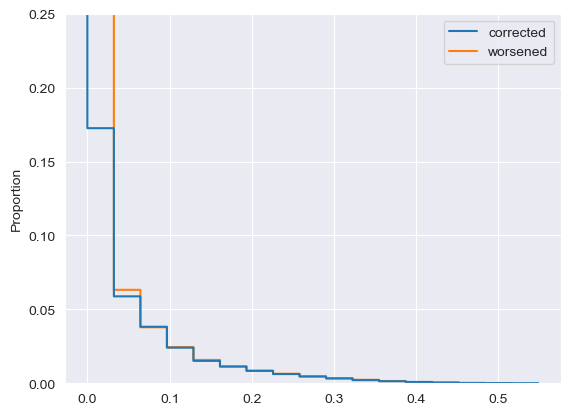

In [183]:
ax = sns.ecdfplot(data=pert_test_results[["corrected", "worsened"]], complementary=True)
ax.set(ylim=(0,0.25))

In [184]:
pert_test_results[pert_test_results["y_outcomes"].map(len) > 2]

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened
idx,,,,,,,
10335045,0,2,True,"{0, 1, 2}","{0, 1}",0.032258,0.000000
10343139,2,1,True,"{0, 1, 2}","{0, 2}",0.032258,0.000000
10446669,1,0,True,"{0, 1, 2}","{1, 2}",0.096774,0.000000
10947943,0,0,True,"{0, 1, 2}","{1, 2}",0.000000,0.290323
10996678,0,0,True,"{0, 1, 2}","{1, 2}",0.000000,0.064516
11031000,1,1,True,"{0, 1, 2}","{0, 2}",0.000000,0.064516
11069650,1,2,True,"{0, 1, 2}","{0, 1}",0.032258,0.000000
11070950,2,2,True,"{0, 1, 2}","{0, 1}",0.000000,0.193548
11071048,2,2,True,"{0, 1, 2}","{0, 1}",0.000000,0.032258


In [185]:
pert_test_results["correct"] = pert_test_results["y_true"] == pert_test_results["y"]
pert_test_results

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened,correct
idx,,,,,,,,
10001243,1,1,False,{1},{},0.0,0.0,True
10003947,1,1,False,{1},{},0.0,0.0,True
10004727,1,1,False,{1},{},0.0,0.0,True
10006126,1,1,False,{1},{},0.0,0.0,True
10006791,1,1,False,{1},{},0.0,0.0,True
...,...,...,...,...,...,...,...,...
9998396,0,0,False,{0},{},0.0,0.0,True
9998430,2,2,False,{2},{},0.0,0.0,True
9998460,1,1,False,{1},{},0.0,0.0,True


<AxesSubplot:xlabel='pert_alarm', ylabel='count'>

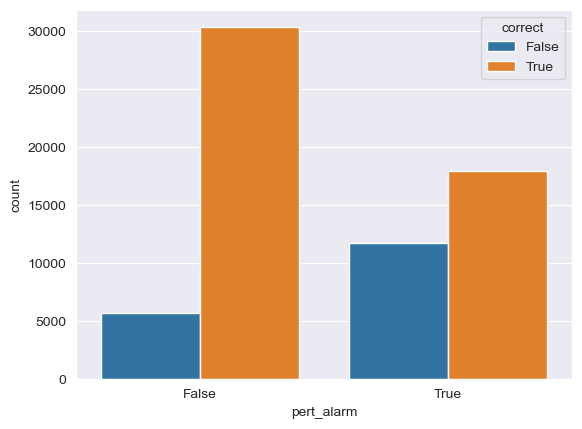

In [186]:
sns.countplot(data = pert_test_results, x="pert_alarm", hue="correct")

In [187]:
def correct_mistakes(row):
    if row.pert_alarm:
        return row.y_true
    else:
        return row.y

def force_mistakes(row):
    if row.worsened >= 0.3 and row.changed_to:
        return random.sample(row.changed_to,1)[0]
    else:
        return row.y

def force_corrections(row):
    if row.corrected >= 0.3:
        return row.y_true
    else:
        return row.y

pert_test_results["y_corrected"] = pert_test_results.apply(correct_mistakes, axis="columns")
pert_test_results["y_forced_mistake"] = pert_test_results.apply(force_mistakes, axis="columns")
pert_test_results["y_forced_correction"] = pert_test_results.apply(force_corrections, axis="columns")

In [188]:
pert_test_results

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened,correct,y_corrected,y_forced_mistake,y_forced_correction
idx,,,,,,,,,,,
10001243,1,1,False,{1},{},0.0,0.0,True,1,1,1
10003947,1,1,False,{1},{},0.0,0.0,True,1,1,1
10004727,1,1,False,{1},{},0.0,0.0,True,1,1,1
10006126,1,1,False,{1},{},0.0,0.0,True,1,1,1
10006791,1,1,False,{1},{},0.0,0.0,True,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
9998396,0,0,False,{0},{},0.0,0.0,True,0,0,0
9998430,2,2,False,{2},{},0.0,0.0,True,2,2,2
9998460,1,1,False,{1},{},0.0,0.0,True,1,1,1


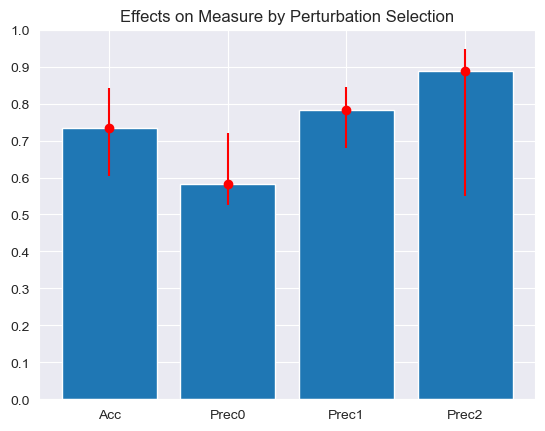

In [221]:
y_errormin = [alarm.get("acc"), alarm.get("prec0"), alarm.get("prec1"), alarm.get("prec2")]
y_errormax = [no_alarm.get("acc"), no_alarm.get("prec0"), no_alarm.get("prec1"), no_alarm.get("prec2")]
y_error = [y_errormin, y_errormax]
y = [real.get("acc"), real.get("prec0"), real.get("prec1"), real.get("prec2")]
for c, v in enumerate(y_errormin):
    y_errormin[c] = y[c] - v
for c, v in enumerate(y_errormax):
    y_errormax[c] = v - y[c]
x = ["Acc", "Prec0", "Prec1", "Prec2"]
plt.bar(x,y)
plt.errorbar(x,y, yerr=y_error, fmt='o', color="r")

plt.yticks(np.arange(start=0, stop=1.1, step = 0.1))
plt.title("Effects on Measure by Perturbation Selection")
plt.show()

In [190]:
print(f"Real values {real}")
print(f"Alarmed values {alarm}")
print(f"Non-alarmed values {no_alarm}")

Real values {'acc': 0.7342897524353733, 'prec0': 0.5829841594276954, 'prec1': 0.7822335673261008, 'prec2': 0.8877551020408163}
Alarmed values {'acc': 0.6043010752688172, 'prec0': 0.5263728323699421, 'prec1': 0.6808811641067097, 'prec2': 0.550185873605948}
Non-alarmed values {'acc': 0.841624816181571, 'prec0': 0.7197207678883072, 'prec1': 0.8440672393243188, 'prec2': 0.948494983277592}


In [191]:
# Scores when all alerted entries are corrected
print_measures(list(pert_test_results["y_corrected"]), list(pert_test_results["y_true"]), [0,1,2])

--------------------
Global measures
Number of entries: 65801
Accuracy: 0.91325
Precision-µ: 0.91325
Recall-µ: 0.91325
F1-Score-µ: 0.91325
=
Precision-M: 0.92420
Recall-M: 0.88410
F1-Score-M: 0.90241
--------------------
Measures for label '0'
Number of entries: 17839
Precision score: 0.90559
Recall score: 0.86356
--------------------
Measures for label '1'
Number of entries: 39370
Precision score: 0.90813
Recall score: 0.95260
--------------------
Measures for label '2'
Number of entries: 8592
Precision score: 0.95889
Recall score: 0.83613


{'acc': 0.9132535979696357,
 'prec0': 0.9055905002645347,
 'prec1': 0.9081311443653446,
 'prec2': 0.9588894821142552}

In [192]:
# Scores when all alerted entries discarded
print_measures(list(pert_test_results[pert_test_results["pert_alarm"] == False]["y"]), list(pert_test_results[pert_test_results["pert_alarm"] == False]["y_true"]), [0,1,2])

--------------------
Global measures
Number of entries: 36041
Accuracy: 0.84162
Precision-µ: 0.84162
Recall-µ: 0.84162
F1-Score-µ: 0.84162
=
Precision-M: 0.83743
Recall-M: 0.78223
F1-Score-M: 0.80624
--------------------
Measures for label '0'
Number of entries: 6558
Precision score: 0.71972
Recall score: 0.62885
--------------------
Measures for label '1'
Number of entries: 22403
Precision score: 0.84407
Recall score: 0.91671
--------------------
Measures for label '2'
Number of entries: 7080
Precision score: 0.94849
Recall score: 0.80113


{'acc': 0.841624816181571,
 'prec0': 0.7197207678883072,
 'prec1': 0.8440672393243188,
 'prec2': 0.948494983277592}

In [193]:
#Scores when all strongly changed perturbations are corrected
print_measures(list(pert_test_results["y_forced_correction"]), list(pert_test_results["y_true"]), [0,1,2])

--------------------
Global measures
Number of entries: 65801
Accuracy: 0.73757
Precision-µ: 0.73757
Recall-µ: 0.73757
F1-Score-µ: 0.73757
=
Precision-M: 0.75447
Recall-M: 0.71785
F1-Score-M: 0.73309
--------------------
Measures for label '0'
Number of entries: 17839
Precision score: 0.58836
Recall score: 0.64090
--------------------
Measures for label '1'
Number of entries: 39370
Precision score: 0.78381
Recall score: 0.78313
--------------------
Measures for label '2'
Number of entries: 8592
Precision score: 0.89123
Recall score: 0.72952


{'acc': 0.7375723773194937,
 'prec0': 0.5883594071634417,
 'prec1': 0.7838112670327435,
 'prec2': 0.8912270723730983}

In [194]:
#Scores when all strongly changed perturbations are changed to wrong entries
print_measures(list(pert_test_results["y_forced_mistake"]), list(pert_test_results["y_true"]), [0,1,2])

--------------------
Global measures
Number of entries: 65801
Accuracy: 0.73092
Precision-µ: 0.73092
Recall-µ: 0.73092
F1-Score-µ: 0.73092
=
Precision-M: 0.74797
Recall-M: 0.71142
F1-Score-M: 0.72664
--------------------
Measures for label '0'
Number of entries: 17839
Precision score: 0.57851
Recall score: 0.63115
--------------------
Measures for label '1'
Number of entries: 39370
Precision score: 0.77846
Recall score: 0.77722
--------------------
Measures for label '2'
Number of entries: 8592
Precision score: 0.88695
Recall score: 0.72591


{'acc': 0.7309159435266941,
 'prec0': 0.5785119720480937,
 'prec1': 0.7784618515785993,
 'prec2': 0.8869453924914675}

## Local Accuracy

In [195]:
pert_test_results

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened,correct,y_corrected,y_forced_mistake,y_forced_correction
idx,,,,,,,,,,,
10001243,1,1,False,{1},{},0.0,0.0,True,1,1,1
10003947,1,1,False,{1},{},0.0,0.0,True,1,1,1
10004727,1,1,False,{1},{},0.0,0.0,True,1,1,1
10006126,1,1,False,{1},{},0.0,0.0,True,1,1,1
10006791,1,1,False,{1},{},0.0,0.0,True,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
9998396,0,0,False,{0},{},0.0,0.0,True,0,0,0
9998430,2,2,False,{2},{},0.0,0.0,True,2,2,2
9998460,1,1,False,{1},{},0.0,0.0,True,1,1,1


In [196]:
# Finding corresponding indexes
correct_indexes = pert_test_results.index[pert_test_results['correct'] == True].tolist()
false_indexes = pert_test_results.index[pert_test_results['correct'] == False].tolist()
alarm_indexes = pert_test_results.index[pert_test_results['pert_alarm'] == True].tolist()

In [197]:
X_test

,DEP_DELAY(MINS),CRS_ELAPSED_TIME(MINS),NR_PREV_ARR_FLIGHTS(1HR),ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN,ARR_MIN_OF_DAY_COS,APPROACH_SPEED(KMH),TAIL_HEIGHT(M),PARKING_AREA(SQM),...,EVENT_FG,EVENT_FU,EVENT_GR,EVENT_GS,EVENT_HZ,EVENT_IC,EVENT_RA,EVENT_SN,EVENT_TS,RUNWAY_ERROR(PERC)
6386798,77,51,64,0.974928,-0.222521,-0.831470,-0.555570,259.280,6.324600,560.293571,...,0,0,0,0,0,0,0,0,0,1.0
6824913,-7,95,72,0.433884,-0.900969,-0.402747,-0.915311,257.428,9.043416,1075.157934,...,0,0,0,0,0,0,0,0,0,0.4
7556876,-2,86,51,0.000000,1.000000,-0.768842,-0.639439,259.280,6.324600,560.293571,...,0,0,0,0,0,0,0,0,0,0.2
10772416,162,95,84,0.000000,1.000000,0.480989,-0.876727,233.352,12.109704,1153.939056,...,0,0,0,0,0,0,0,0,0,0.0
7282245,-11,181,63,-0.433884,-0.900969,-0.942641,-0.333807,233.352,12.109704,1153.939056,...,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9980295,-3,102,68,-0.433884,-0.900969,0.731354,-0.681998,264.836,13.639800,2071.070234,...,0,0,0,0,0,0,0,0,0,0.8
9983451,-3,115,30,-0.433884,-0.900969,-0.342020,0.939693,261.132,12.624816,1445.094760,...,0,0,0,0,0,0,0,0,0,0.6
7026317,54,86,75,0.781831,0.623490,-0.816642,0.577145,255.576,9.000744,1525.176514,...,0,0,0,0,0,0,0,0,0,0.6
10352441,2,150,53,0.000000,1.000000,-0.980785,0.195090,261.132,12.624816,1445.094760,...,0,0,0,0,0,0,0,0,0,0.4


In [198]:
# Find correct vs false fraction
frac_fc = len(false_indexes) / len(correct_indexes) 
frac_alarm = len(alarm_indexes) / len(X_test.index)
print(f"Fraction false vs. correct is: {frac_fc:.4f} (Rounded)")
print(f"Fraction alarm vs. no alarm is: {frac_alarm:.4f} (Rounded)")

Fraction false vs. correct is: 0.3619 (Rounded)
Fraction alarm vs. no alarm is: 0.4523 (Rounded)


In [199]:
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
from main.utils import time_utils

# Scaling Test-Data
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test, y_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Sample X_test
sample_idxs = list(pert_test_results.groupby("pert_alarm", group_keys=False).apply(lambda x: x.sample(frac = 0.1)).index.astype(int))
X_test_sampled = X_test_scaled.loc[sorted(sample_idxs)]
X_test_sampled.index = range(len(X_test_sampled.index))
X_test_sampled

,DEP_DELAY(MINS),CRS_ELAPSED_TIME(MINS),NR_PREV_ARR_FLIGHTS(1HR),ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN,ARR_MIN_OF_DAY_COS,APPROACH_SPEED(KMH),TAIL_HEIGHT(M),PARKING_AREA(SQM),...,EVENT_FG,EVENT_FU,EVENT_GR,EVENT_GS,EVENT_HZ,EVENT_IC,EVENT_RA,EVENT_SN,EVENT_TS,RUNWAY_ERROR(PERC)
0,7.432675,-0.281605,0.419548,-1.179173,0.876772,1.421947,-0.595688,0.335079,-1.654315,-1.808123,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
1,-0.299095,-0.168147,1.345426,-1.179173,0.876772,1.172762,-0.830960,0.335079,-1.654315,-1.808123,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
2,-0.385003,-0.187056,-0.179549,-1.179173,0.876772,1.443730,-0.569405,0.335079,-1.654315,-1.808123,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
3,-0.234663,-0.735436,-0.560793,-1.179173,0.876772,-0.114233,-1.020770,0.335079,2.841814,5.472442,...,8.468075,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
4,-0.299095,-0.754346,-0.669720,-1.179173,0.876772,0.491751,-1.101117,-0.296069,-0.536964,0.376109,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6575,-0.277617,-0.432882,-0.778647,-1.179173,0.876772,1.477503,-0.526264,-0.927218,0.748371,-0.176153,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,-0.276463,-0.295764,-0.120373,-2.021524
6576,-0.191709,-0.432882,-0.288476,-1.179173,0.876772,-0.916591,-0.279825,0.335079,2.396401,2.840259,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,-0.276463,-0.295764,-0.120373,-2.021524
6577,-0.191709,-0.565249,-0.669720,-1.179173,0.876772,1.615350,-0.310767,1.281802,1.399947,1.611864,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,-0.276463,-0.295764,-0.120373,-2.021524
6578,-0.234663,1.590450,-0.506330,-1.179173,0.876772,0.402288,-1.107246,0.335079,0.757280,0.359495,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,-0.276463,-0.295764,-0.120373,-2.021524


In [200]:
# Sample y_test
y_test_true_sampled = y_test.loc[sorted(sample_idxs)]
y_test_true_sampled.index = range(len(y_test_true_sampled.index))

y_test_pred_sampled = y_test_pred.copy()
y_test_pred_sampled.index = y_test.index
y_test_pred_sampled = y_test_pred_sampled.loc[sorted(sample_idxs)]
y_test_pred_sampled.index = range(len(y_test_pred_sampled.index))
y_test_pred_sampled

,0
0,2
1,2
2,1
3,1
4,1
...,...
6575,0
6576,0
6577,1
6578,0


In [201]:
def calc_manh_dist_matrix(X: pd.DataFrame):   
    X = X.to_numpy()
    n = X.shape[0]
    D = np.zeros((n,n))
    D_asym = np.zeros((n,n))
    start, start_str = time_utils.print_time()
    print(f"Start distance calc at {start_str}")
    for i in range(n):
        print(f"{i+1}/{n}:")
        for j in range(i,n):
            D[i,j] = distance.cityblock(X[i], X[j])
            D[j,i] =  D[i,j]
            D_asym[i,j] = D[i,j]
            D_asym[j,i] = np.nan
    end, end_str = time_utils.print_time()
    print(f"End distance calc at {end_str}\n Took time: {end-start}")
    return D, D_asym

In [202]:
distance_matrix, dist_matrix_asym = calc_manh_dist_matrix(X_test_sampled)
distance_matrix

Start distance calc at 2024_06_17 20:22
1/6580:
2/6580:
3/6580:
4/6580:
5/6580:
6/6580:
7/6580:
8/6580:
9/6580:
10/6580:
11/6580:
12/6580:
13/6580:
14/6580:
15/6580:
16/6580:
17/6580:
18/6580:
19/6580:
20/6580:
21/6580:
22/6580:
23/6580:
24/6580:
25/6580:
26/6580:
27/6580:
28/6580:
29/6580:
30/6580:
31/6580:
32/6580:
33/6580:
34/6580:
35/6580:
36/6580:
37/6580:
38/6580:
39/6580:
40/6580:
41/6580:
42/6580:
43/6580:
44/6580:
45/6580:
46/6580:
47/6580:
48/6580:
49/6580:
50/6580:
51/6580:
52/6580:
53/6580:
54/6580:
55/6580:
56/6580:
57/6580:
58/6580:
59/6580:
60/6580:
61/6580:
62/6580:
63/6580:
64/6580:
65/6580:
66/6580:
67/6580:
68/6580:
69/6580:
70/6580:
71/6580:
72/6580:
73/6580:
74/6580:
75/6580:
76/6580:
77/6580:
78/6580:
79/6580:
80/6580:
81/6580:
82/6580:
83/6580:
84/6580:
85/6580:
86/6580:
87/6580:
88/6580:
89/6580:
90/6580:
91/6580:
92/6580:
93/6580:
94/6580:
95/6580:
96/6580:
97/6580:
98/6580:
99/6580:
100/6580:
101/6580:
102/6580:
103/6580:
104/6580:
105/6580:
106/6580:
107/6580

array([[ 0.        , 12.81059315,  8.55938997, ..., 36.94755657,
        34.59234661, 33.21060354],
       [12.81059315,  0.        ,  5.71734695, ..., 29.11882511,
        25.48187841, 24.28409676],
       [ 8.55938997,  5.71734695,  0.        , ..., 28.96385151,
        26.42976817, 25.19416723],
       ...,
       [36.94755657, 29.11882511, 28.96385151, ...,  0.        ,
         9.24766079,  9.6027458 ],
       [34.59234661, 25.48187841, 26.42976817, ...,  9.24766079,
         0.        ,  5.12844785],
       [33.21060354, 24.28409676, 25.19416723, ...,  9.6027458 ,
         5.12844785,  0.        ]])

In [203]:
np.fill_diagonal(distance_matrix, np.nan)
distance_matrix

array([[        nan, 12.81059315,  8.55938997, ..., 36.94755657,
        34.59234661, 33.21060354],
       [12.81059315,         nan,  5.71734695, ..., 29.11882511,
        25.48187841, 24.28409676],
       [ 8.55938997,  5.71734695,         nan, ..., 28.96385151,
        26.42976817, 25.19416723],
       ...,
       [36.94755657, 29.11882511, 28.96385151, ...,         nan,
         9.24766079,  9.6027458 ],
       [34.59234661, 25.48187841, 26.42976817, ...,  9.24766079,
                nan,  5.12844785],
       [33.21060354, 24.28409676, 25.19416723, ...,  9.6027458 ,
         5.12844785,         nan]])

In [204]:
distance_list = distance_matrix.flatten()
distance_list = list(distance_list[~np.isnan(distance_list)])

print(f"Number of entries: {len(distance_list)}")

Number of entries: 43289820


<AxesSubplot:>

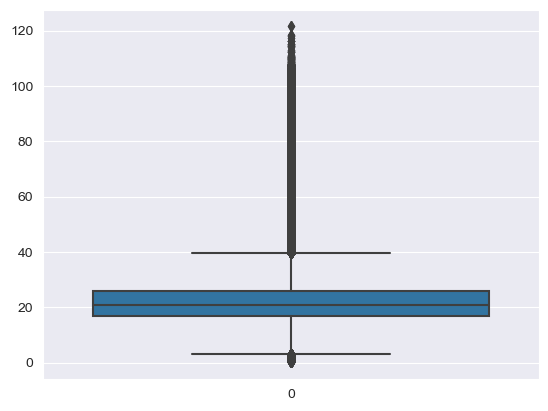

In [205]:
sns.boxplot(distance_list)

In [206]:
neigh_thresh = np.percentile(distance_list,0.2)
neigh_thresh

6.69821637083751

In [207]:
np.fill_diagonal(dist_matrix_asym, 0)
boolean_mask = np.where((dist_matrix_asym < neigh_thresh) & (~np.isnan(dist_matrix_asym)), True, False)
boolean_mask

array([[ True, False, False, ..., False, False, False],
       [False,  True,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False, False,  True]])

In [208]:
true_indices_list = []
for row in boolean_mask:
    true_indices = np.where(row)[0]
    true_indices_list.append(true_indices.tolist())
true_indices_list

[[0],
 [1, 2],
 [2, 13],
 [3],
 [4],
 [5],
 [6],
 [7, 10, 11, 14],
 [8],
 [9],
 [10, 14, 16],
 [11],
 [12],
 [13],
 [14, 16],
 [15],
 [16],
 [17],
 [18, 21, 35],
 [19],
 [20],
 [21],
 [22],
 [23],
 [24],
 [25, 26],
 [26],
 [27, 33, 6443],
 [28, 6206, 6209],
 [29],
 [30],
 [31],
 [32],
 [33, 6447],
 [34],
 [35],
 [36, 53],
 [37,
  39,
  43,
  46,
  48,
  356,
  675,
  678,
  680,
  682,
  1484,
  1486,
  1714,
  1717,
  1721,
  1723,
  2100,
  2102,
  2105,
  2106,
  2107,
  2108,
  2110,
  2113,
  2137,
  2141,
  2378,
  2773,
  4274,
  4275,
  5010,
  5736,
  6328,
  6338,
  6340,
  6466],
 [38],
 [39,
  43,
  46,
  47,
  48,
  58,
  359,
  1055,
  1056,
  1589,
  1593,
  1598,
  1713,
  1714,
  2088,
  2101,
  2105,
  2106,
  2107,
  2109,
  2112,
  4667,
  4677,
  5456,
  6464],
 [40],
 [41],
 [42],
 [43,
  46,
  48,
  671,
  678,
  682,
  1589,
  1717,
  1721,
  2100,
  2102,
  2105,
  2106,
  2107,
  2108,
  2113,
  2137,
  2141,
  2666,
  2773,
  4275,
  4677,
  6328,
  6329,
  6

In [209]:
np.median([len(elem) for elem in true_indices_list])

4.0

In [210]:
X_test_sampled

,DEP_DELAY(MINS),CRS_ELAPSED_TIME(MINS),NR_PREV_ARR_FLIGHTS(1HR),ARR_DAY_SIN,ARR_DAY_COS,ARR_MIN_OF_DAY_SIN,ARR_MIN_OF_DAY_COS,APPROACH_SPEED(KMH),TAIL_HEIGHT(M),PARKING_AREA(SQM),...,EVENT_FG,EVENT_FU,EVENT_GR,EVENT_GS,EVENT_HZ,EVENT_IC,EVENT_RA,EVENT_SN,EVENT_TS,RUNWAY_ERROR(PERC)
0,7.432675,-0.281605,0.419548,-1.179173,0.876772,1.421947,-0.595688,0.335079,-1.654315,-1.808123,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
1,-0.299095,-0.168147,1.345426,-1.179173,0.876772,1.172762,-0.830960,0.335079,-1.654315,-1.808123,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
2,-0.385003,-0.187056,-0.179549,-1.179173,0.876772,1.443730,-0.569405,0.335079,-1.654315,-1.808123,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
3,-0.234663,-0.735436,-0.560793,-1.179173,0.876772,-0.114233,-1.020770,0.335079,2.841814,5.472442,...,8.468075,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
4,-0.299095,-0.754346,-0.669720,-1.179173,0.876772,0.491751,-1.101117,-0.296069,-0.536964,0.376109,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,1.567023,-0.295764,-0.120373,1.168149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6575,-0.277617,-0.432882,-0.778647,-1.179173,0.876772,1.477503,-0.526264,-0.927218,0.748371,-0.176153,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,-0.276463,-0.295764,-0.120373,-2.021524
6576,-0.191709,-0.432882,-0.288476,-1.179173,0.876772,-0.916591,-0.279825,0.335079,2.396401,2.840259,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,-0.276463,-0.295764,-0.120373,-2.021524
6577,-0.191709,-0.565249,-0.669720,-1.179173,0.876772,1.615350,-0.310767,1.281802,1.399947,1.611864,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,-0.276463,-0.295764,-0.120373,-2.021524
6578,-0.234663,1.590450,-0.506330,-1.179173,0.876772,0.402288,-1.107246,0.335079,0.757280,0.359495,...,-0.118091,-0.084363,-0.003898,-0.003898,-0.045004,-0.115753,-0.276463,-0.295764,-0.120373,-2.021524


In [211]:
pert_test_results.index = pert_test_results.index.astype(int)
pert_test_results_sampled = pert_test_results.loc[sample_idxs]
pert_test_results_sampled.index = range(len(pert_test_results_sampled.index))
pert_test_results_sampled

,y_true,y,pert_alarm,y_outcomes,changed_to,corrected,worsened,correct,y_corrected,y_forced_mistake,y_forced_correction
0,1,1,False,{1},{},0.000000,0.000000,True,1,1,1
1,1,1,False,{1},{},0.000000,0.000000,True,1,1,1
2,2,2,False,{2},{},0.000000,0.000000,True,2,2,2
3,0,0,False,{0},{},0.000000,0.000000,True,0,0,0
4,1,1,False,{1},{},0.000000,0.000000,True,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
6575,1,0,True,"{0, 1}",{1},0.032258,0.000000,False,1,0,0
6576,1,1,True,"{0, 1}",{0},0.000000,0.064516,True,1,1,1
6577,0,0,True,"{0, 1}",{1},0.000000,0.032258,True,0,0,0
6578,1,1,True,"{0, 1}",{0},0.000000,0.032258,True,1,1,1


In [212]:
res_list = []
for list in true_indices_list:
    res_list.append(accuracy_score(y_test_true_sampled.loc[list], y_test_pred_sampled.loc[list]))
res_list 

[1.0,
 0.5,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.75,
 1.0,
 1.0,
 0.6666666666666666,
 1.0,
 1.0,
 1.0,
 0.5,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.5,
 1.0,
 1.0,
 0.5,
 0.7222222222222222,
 0.0,
 0.8,
 1.0,
 1.0,
 1.0,
 0.6923076923076923,
 1.0,
 1.0,
 1.0,
 0.7647058823529411,
 0.6842105263157895,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.5555555555555556,
 0.5333333333333333,
 0.55,
 0.5,
 0.3333333333333333,
 0.7222222222222222,
 0.5,
 0.7272727272727273,
 0.75,
 0.6666666666666666,
 0.8,
 1.0,
 0.7142857142857143,
 0.5,
 0.6666666666666666,
 0.5,
 0.6666666666666666,
 0.7142857142857143,
 1.0,
 0.8,
 0.7142857142857143,
 0.46153846153846156,
 0.6,
 0.8,
 0.5,
 0.5,
 0.8260869565217391,
 0.5,
 0.6,
 0.7142857142857143,
 1.0,
 0.0,
 0.7142857142857143,
 0.6666666666666666,
 0.5,
 0.2,
 0.4,
 0.5714285714285714,
 0.8421052631578947,
 0.5714285714285714,
 0.5,
 0.75,
 1.0,
 0.4,
 0.6666666666666666,
 1.0,
 0

In [213]:
alarm_idx = pert_test_results_sampled[pert_test_results_sampled["pert_alarm"] == True].index
no_alarm_idx = pert_test_results_sampled[pert_test_results_sampled["pert_alarm"] == False].index

alarm_acc = np.mean([res_list[i] for i in alarm_idx])
no_alarm_acc = np.mean([res_list[i] for i in no_alarm_idx])

In [214]:
alarm_acc

0.720180494983561

In [215]:
no_alarm_acc

0.7328305984619866